# Aquaseca basic domain
## Former Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 


*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [2]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv
import seaborn as sns
from pyDOE import *

#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)


moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
#modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws = "D:/mfoutput"

#jupyter specific--included to show plots in notebook
%matplotlib inline 

Parameter Values

K1, K2, and K3 = [5, 25, 100] # baseline Kx=Ky=Kz value in all zones (m/day)

Kz ratio_lowK = [1e-6, 1e-2, 1] # ratio of Kz in low-K layer to baseline K (-)

Sy = [0.05, 0.1, 0.3] # specific yield (-)

R_mountains = [1e-5, 3e-5, 5e-5] # recharge rate in mountains (m/day)

ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)

ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)

Kratio_streambed = [1e-2,1e-1, 1] # ratio of K in streambed to baseline K (-)

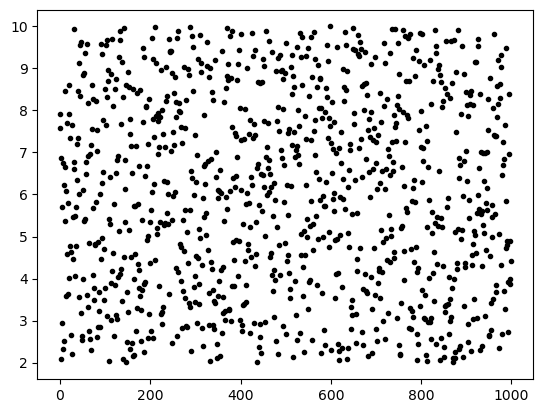

9.99793051205671
2.002768210199526


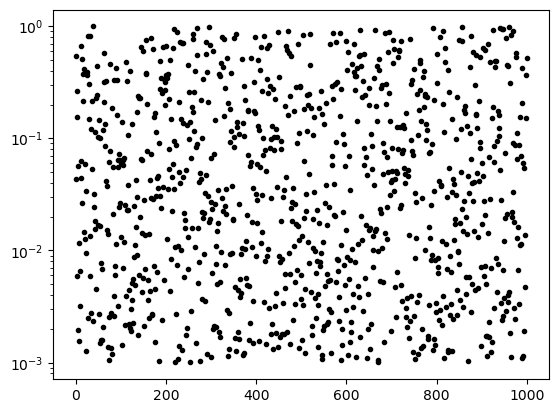

0.9941400752083006
0.0010030695319775366


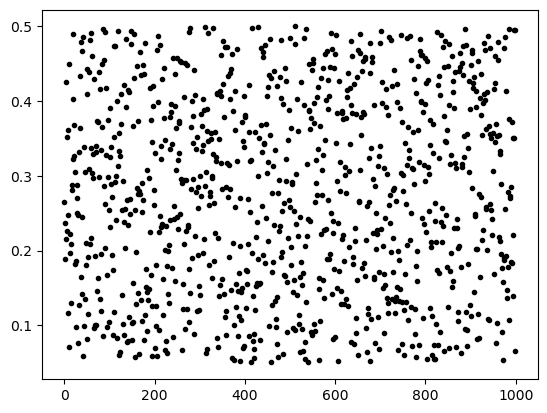

0.4999561352386594
0.05019005843122129


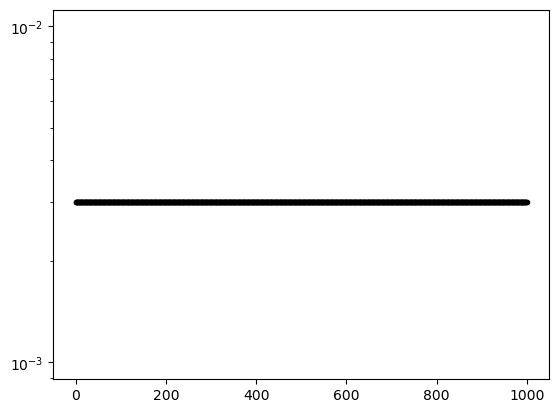

0.003000000000000001
0.003000000000000001


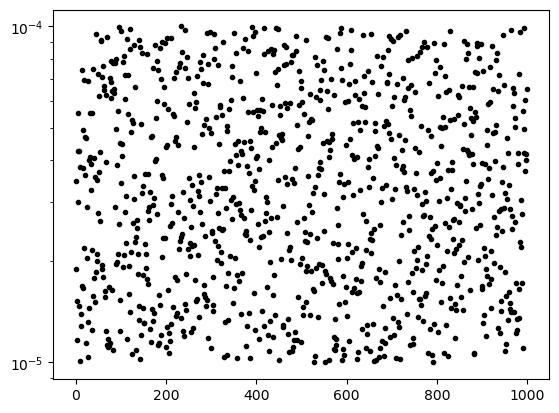

9.998272944181638e-05
1.0000767985468623e-05


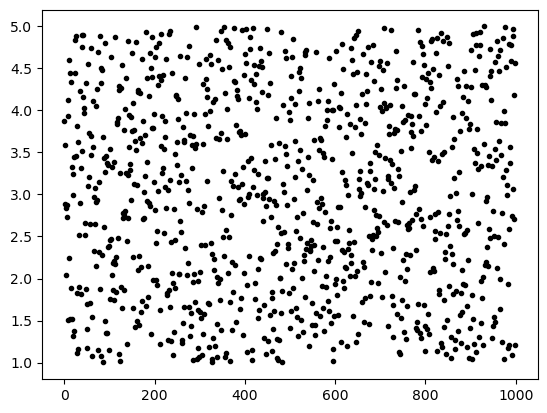

4.996280574087214
1.0021129098302772


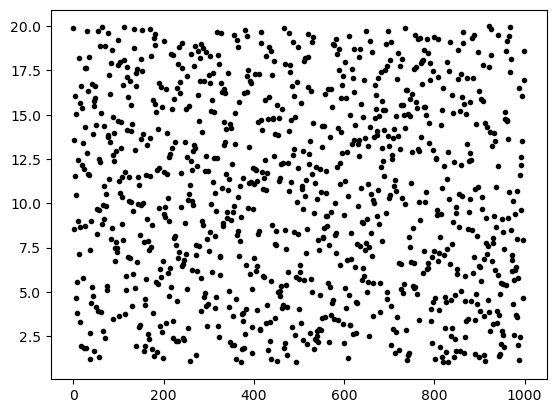

19.982093373204826
1.0166137934465893


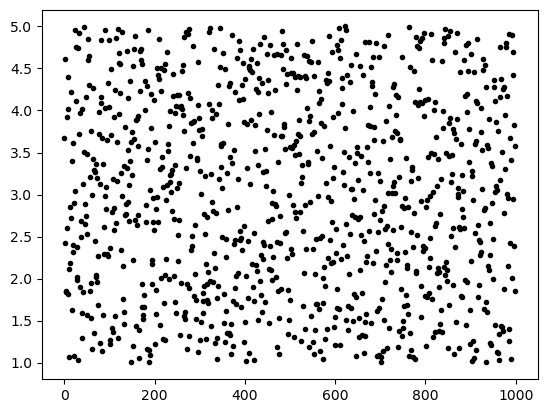

4.9995151541582015
1.0022749687795758


In [16]:
#Set up parameter for ensemble
# K_h = [2, 50]       #was 5 to 100                                                                                                                      # base case retardation
# Kz_ratio = [0.001, 1]     
# Ka = [5, 100] #streambed K
# Sy = [0.05,0.3]                                                                                                                         
# R_mtn = [0.00003,0.00005]  #set 2e-5 as minimum for convergence
# ET_val = [0.0001,0.000001]   
# ET_ratio_rip = [1,3]
# krs = [0.0001, 0.005]


#Set up parameter for ensemble
K_h = [2, 10]#[2, 10]  #hone in on this one perhaps use 0.05                                                                                                                        
Kz_ratio = [0.001, 1]                                                                                                                   
Sy = [0.05,0.5] #Sy = [0.05,0.5]                                                                                                                            
R_mtn = [0.003,0.003]  #set 2e-5 as minimum for convergence
ET_val = [0.00001,0.0001] #[0.000001,0.00001]   
ET_ratio_rip = [1,5]
Krs = [1, 20]#krs = [0.001, 0.01] 
#Anis = [0.01, 1] # anistrophy! - not used below
pump_rate = [1,5]

num = 1000
npars = 8
#latin hyper cube sampling
sampling = lhs(npars, samples = num)
#print(sampling)
params = np.array([K_h, Kz_ratio, Sy, R_mtn, ET_val, ET_ratio_rip, Krs, pump_rate])
#params = np.array([K_h, Kz_ratio, Sy, ET_val, ET_ratio_rip, Krs, pump_rate])

logpars = [1,3,4]
for i in range(npars):
    if(i in logpars):
        #log
        sampling[:,i] = 10**(np.log10(params[i][0]) + (np.log10(params[i][1]) - np.log10(params[i][0]))*sampling[:,i])
    else:
        #Linear 
        sampling[:,i] = params[i][0] + (params[i][1] - params[i][0])*sampling[:,i]
    
for i in range(npars):
    plt.plot(sampling[:,i], 'k.')
    if i in logpars:
        plt.yscale('log')
    plt.show()
    print(np.max(sampling[:,i]))
    print(np.min(sampling[:,i]))
    
    
#np.savetxt("ModflowParams7-750Test14.txt", sampling)
#np.savetxt("ModflowParams8-1000Test5.txt", sampling)

## 2. Discretization and other inputs

In [9]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

width = 100
dx= width #width of grid cells in x direction 
dy= width #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 10e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (25.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 


rip_rows_forced = (22.0, 29.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

Rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
Rip_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
## Recharge
rech=0.003  #m/d


rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 20 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech

## Boundary conditions
h_right = 65
h_right = 68.5 #was 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#Aqua Seca Well well
pumping = -2000 #m3/day #was 2500 for 1000test1 pars
well_row =   19 #12
well_col =   32 #14
#well_loc = (2,well_row, well_col)
#well = [2,well_row, well_col, pumping] 

wel_spd =  {0: [2,well_row, well_col, pumping]}
#well_val = np.tile([1,0],sim_years+1)
# for p in range(1, nper):   
#     #pumping = 0
#     wel_spd[p] =  [2,well_row, well_col, pumping*well_val[p]]

# print(wel_spd)
#print(ztop)


### Layering

In [10]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array

## Make some changes to the parameters
bot_elev = 0. #0
mid_elev = 40. #40
top_elev = 45. #45

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [11]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,0,49]=0
ibound[:,49,49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#new bottom no flow zone constriction
ibound[:,1,19:]=0
ibound[:,2,25:]=0
ibound[:,3,30:]=0
ibound[:,4,33:]=0
ibound[:,5,36:]=0
ibound[:,6,39:]=0
ibound[:,7,41:]=0
ibound[:,8,43:]=0
ibound[:,9,45:]=0
ibound[:,10,46:]=0
ibound[:,11,47:]=0
ibound[:,12,48:]=0

ibound[:,48,19:]=0
ibound[:,47,25:]=0
ibound[:,46,30:]=0
ibound[:,45,33:]=0
ibound[:,44,36:]=0
ibound[:,43,39:]=0
ibound[:,42,41:]=0
ibound[:,41,43:]=0
ibound[:,40,45:]=0
ibound[:,39,46:]=0
ibound[:,38,47:]=0
ibound[:,37,48:]=0

#np.savetxt("ibound_lyr1.txt", ibound[0])

## Stream

In [1]:
#SFR package inputs

reach = np.recarray((nrow,), dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),('strtop', '<f4')])

reach[:][:] = 0 # zero it out
reach['k'][:] = 0
reach['i'][:] = int(nrow/2)  #set it to the middle row
reach['j'][:] = [i for i in range(ncol)] #all columns in the middle row
reach['iseg'][:] = 1 #segment number - we only have 1 so all cells - segment number starts with 1!
#reach['iseg'][25:] = 2
reach['ireach'][:50] = [i for i in range(1,51)] #number the 50 reaches - starts with 1!
#reach['ireach'][25:] = [i for i in range(1,26)]
reach['rchlen'][:] = dx * 1.2 #Moderate sinuosity for steeper section from Rosgen 
#reach['rchlen'][25:] = dx * 1.5 #Higher sinuosity for lower slope section from Rosgen 

str_elevs = np.linspace(ztop[25][0],ztop[25][-1],50) - 5 #ztop[25] #[i for i in ztop[25]] #This was necessary in Transient but not in SS - otherwise it sets the stream elevation to 0 - not sure whyyy

reach['strtop'][:] = ztop[25] - 5 #+ (ztop[25] - str_elevs)*0.5 - 5

#print(reach)
dtype = flopy.modflow.ModflowSfr2.get_default_segment_dtype()
indices = ['nseg','width1','width2','icalc','roughch','flow','outseg','iupseg','hcond1','hcond2','thickm1','thickm2','etsw','pptsw','elevup','elevdn']
#print(dtype)
#print(dtype[indices])
seg_data = np.recarray((1,), dtype[indices])
seg_data[:] = 0
seg_data['width1'] = 5 #2
seg_data['width2'] = 5 #2
seg_data['icalc'] = 1
seg_data['nseg'] = 1
seg_data['roughch'] = 0.045
seg_data['flow'] = 100
seg_data['hcond1'] = 0.0001
seg_data['hcond2'] = 0.0001
seg_data['thickm1'] = 2
seg_data['thickm2'] = 2
#seg_data['elevup'] = 100
#seg_data['elevdn'] = 70
seg_data['etsw'] = 0
seg_data['pptsw'] = 0
seg_data['elevup'] = reach['strtop'][0]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'] = reach['strtop'][-1]
segment_data = seg_data

nstrm = len(reach)  # number of reaches
nss = 1 #len(seg_data[0])  # number of segments
nsfrpar = 0  # number of parameters (not supported)
nparseg = 0
const = 86400 #turns out were in meters and days so according to flopy this should be 1 for meters x 86400 for days   # constant for manning's equation, units of cfs
dleak = 0.0001 # 0.0001  # closure tolerance for stream stage computation
ipakcb = 53  # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81  # flag for writing SFR output to text file
dataset_5 = {0: [nss, 0, 0]}  # dataset 5 (see online guide)

str_elevs = np.linspace(ztop[25][24]-2,ztop[25][-1]-1,26)
streamtest = []
streamtest = ztop[25] -2
streamtest[24:] = str_elevs
print(ztop[25][-1] - 5)
plt.plot(ztop[25], label='Model Top layer Elev')
plt.plot(ztop[25]-1, label='Original Stream Elev')
plt.plot(streamtest, label='Stream test')
plt.plot(reach['strtop'][:], label = 'Final Stream Elev')
plt.xlabel('Stream Reach')
plt.ylabel('Elevation (m)')
plt.legend()

NameError: name 'np' is not defined

## create packages and run model

In [23]:
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test11.pkl')
#print(well_head_df.index.values)

print(sampling[well_head_df.index.values].shape)

(957, 8)


In [24]:
#create model object

#sampling = np.loadtxt("../params/ModflowParams7-750Test12.txt")
#sampling = np.loadtxt("ModflowParams7-750Test14.txt")
#the parameter test numbes differ from the scenario run test #s
#the test 3 params are used for both test 3 and test 4 scenarios - test 4 just has a higher h boundary 12/6/23
#Test 5 params has smaller Recharge range (0.025-0.035) - the scenarios named Test 6 use Test 5 pars but K is set to 5 (in this cell)
#test 7 uses the test 4 pars (varying K and recharge) but added sinuosity by increase reach length per cell (higher sinosity in lower slopes)
#Test 8 uses test 5 pars (constant reacharge at 0.003 and set the K to 5 below) - includes sinuosity of test 7

#test 9 uses test 4 pars but holds K constant at 5
#test 10 uses the test4 pars but holds Recharge constant at 0.003
#test 11 holds them both constant with test 4 pars
sampling = np.loadtxt("ModflowParams8-1000Test4.txt")

#Testing if this matches
#data = np.loadtxt("../outputs/ModflowSfrWellOutput750Test3.txt")
#sampling = data[:,:-1]

#Using only the members in the ensemble after we cull the herd - 
members = well_head_df.index.values

error_list = []
#print(sampling)
num = len(sampling)
#num = 100
leakage_array = np.zeros((num,1))
depth_array = np.zeros((num,1))

testnum = 11

#for i in range(num):
for i in members:
    #print(sampling[i])
    modelname = "ScenarioSfrWell1000Test"+str(testnum)+"NoPumping_"+str(i)
    m = flopy.modflow.Modflow(modelname,model_ws = modws, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    #Layer properties - lpf
    ## make horizontal K np arrays
    #Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = 5# sampling[i][0]# assign the original value to the entire array

    ## Make a arrays for the K values
    #Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = 5#sampling[i][0]#* sampling[i][7]                # assign the original value to the entire array
    
    #restrictive layer
    Kz[1,:,10:49] = sampling[i][0] * sampling[i][1] #* sampling[i][7]       #Replace K in the middle layer with the lower value
    Kh[1,:,10:49] = sampling[i][0] * sampling[i][1]     
    #changed to 10 for start of restrictive layer
    
    Sy = sampling[i][2]
    
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, #laywet = [1,1,1],
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    #ET - evt
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = sampling[i][4]
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = (sampling[i][4] * sampling[i][5])
   
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

    #Recharge - rch
    rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]= 0.003#sampling[i][3]
   
    rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

    seg_data['hcond1'] = sampling[i][6] 
    seg_data['hcond2'] = sampling[i][6]
    
    sfr = flopy.modflow.ModflowSfr2(
        model = m,
        nstrm=nstrm,
        nss=nss,
        const=const,
        dleak=dleak,
        ipakcb=ipakcb,
        #istcb1 = 81,
        istcb2=istcb2,
        reach_data=reach,
        segment_data=seg_data,
        #channel_geometry_data=channel_geometry_data,
        #channel_flow_data=channel_flow_data,
        dataset_5=dataset_5)
    
    
    #Well - wel
    wel_spd =  {0: [2,well_row, well_col,0]}
    #wel_spd =  {0: [2,well_row, well_col,pumping*sampling[i][7]]}
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    #Output control - OC 
    spd = {(-1, -1): [],
        (0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, 
                               mxiter=100, iter1=200, 
                               relax = 0.97
                               # damp = 0.7
                              )
   # chk = sfr.check()

    #write the inputs
    #sfr.plot(key='iseg')
    m.write_input()   
    
    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=False)
    if not success:
        #raise Exception('MODFLOW did not terminate normally.')      
        print('MODFLOW did not terminate normally. Parameters saved to file')
        #save parameters        
        error_list.append(np.hstack((np.array(i),sampling[i])))
        leakage_array[i] = -1
        depth_array[i] = -1
    else:  
        sfrout = SfrFile(modws+'/'+ modelname+'.sfr.out')
        df = sfrout.get_dataframe()
        leakage_array[i] = df.Qout[25]
        depth_array[i] = df.depth[25]
        
combined = np.hstack((sampling[:],leakage_array))

if error_list:
    np.savetxt("ErrorSS_SfrWell1000Test"+str(testnum)+"NoPumping.txt", error_list)
    print(len(error_list))
    eidx = np.array(error_list)[:,0].astype(int)
    print(eidx)
    #pumping
    #error_free = np.delete(combined, eidx, axis=0) 
    #no Pumping
    error_free = [i for i in members if i not in eidx]
else:
    print('No Errors')
    error_free = combined

np.savetxt("ModflowSfrWellOutput1000Test"+str(testnum)+"NoPumping.txt", error_free)

FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_0.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:24
 Elapsed run time:  0.504 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPump

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:33
 Elapsed run time:  0.416 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_16.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:33

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:34
 Elapsed run time:  0.422 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FL

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:45
 Elapsed run time:  0.641 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
MODFLOW did not terminate normally. Parameters saved to file
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_29.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:45

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:45
 Elapsed run time:  0.437 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                            

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:55
 Elapsed run time:  0.388 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_42.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:01:56
 Elapsed run time:  0.426 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FL

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:05
 Elapsed run time:  0.373 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_56.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:05

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:06
 Elapsed run time:  0.392 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FL

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:17
 Elapsed run time:  0.598 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
MODFLOW did not terminate normally. Parameters saved to file
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_69.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:17

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:17
 Elapsed run time:  0.427 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                            

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:26
 Elapsed run time:  0.561 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
MODFLOW did not terminate normally. Parameters saved to file
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_83.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:27
 Elapsed run time:  0.512 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                            

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:37
 Elapsed run time:  0.470 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_96.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:37
 Elapsed run time:  0.331 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FL

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:47
 Elapsed run time:  0.479 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_109.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:47
 Elapsed run time:  0.428 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:58
 Elapsed run time:  0.429 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_123.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:02:59
 Elapsed run time:  0.448 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:08
 Elapsed run time:  0.383 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_136.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:09

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:09
 Elapsed run time:  0.365 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:18
 Elapsed run time:  0.450 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_149.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:19

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:19
 Elapsed run time:  0.447 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:30
 Elapsed run time:  0.482 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_162.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:30

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:31
 Elapsed run time:  0.297 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:40
 Elapsed run time:  0.433 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_177.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:40

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:41
 Elapsed run time:  0.444 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:49
 Elapsed run time:  0.403 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_192.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:50

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:50
 Elapsed run time:  0.412 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:03:59
 Elapsed run time:  0.336 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_205.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:00

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:00
 Elapsed run time:  0.434 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:14
 Elapsed run time:  0.322 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_218.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:14
 Elapsed run time:  0.387 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:23
 Elapsed run time:  0.439 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_234.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:24

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:24
 Elapsed run time:  0.389 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:37
 Elapsed run time:  0.332 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_249.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:37
 Elapsed run time:  0.351 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:46
 Elapsed run time:  0.324 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_263.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:47
 Elapsed run time:  0.362 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:56
 Elapsed run time:  0.388 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_276.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:57

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:04:57
 Elapsed run time:  0.425 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:06
 Elapsed run time:  0.432 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_289.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:07

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:07
 Elapsed run time:  0.545 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:17
 Elapsed run time:  0.469 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_303.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:17

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:17
 Elapsed run time:  0.306 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:26
 Elapsed run time:  0.372 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_316.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:27
 Elapsed run time:  0.423 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:36
 Elapsed run time:  0.492 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_329.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:37
 Elapsed run time:  0.346 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:48
 Elapsed run time:  0.358 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_343.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:49
 Elapsed run time:  0.443 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:59
 Elapsed run time:  0.435 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_356.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:05:59
 Elapsed run time:  0.360 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:09
 Elapsed run time:  0.458 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_369.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:09

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:10
 Elapsed run time:  0.388 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:20
 Elapsed run time:  0.494 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_382.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:21

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:21
 Elapsed run time:  0.480 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:30
 Elapsed run time:  0.414 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_395.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:31

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:31
 Elapsed run time:  0.467 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:40
 Elapsed run time:  0.447 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_408.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:41

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:41
 Elapsed run time:  0.303 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:50
 Elapsed run time:  0.445 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_423.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:51

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:06:51
 Elapsed run time:  0.424 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:02
 Elapsed run time:  0.372 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_436.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:02

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:03
 Elapsed run time:  0.435 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:12
 Elapsed run time:  0.620 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
MODFLOW did not terminate normally. Parameters saved to file
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_449.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:13
 Elapsed run time:  0.480 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                           

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:22
 Elapsed run time:  0.489 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_462.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:23
 Elapsed run time:  0.463 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:33
 Elapsed run time:  0.368 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_476.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:33

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:34
 Elapsed run time:  0.457 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:43
 Elapsed run time:  0.406 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_489.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:43

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:44
 Elapsed run time:  0.440 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:53
 Elapsed run time:  0.432 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_502.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:07:54
 Elapsed run time:  0.436 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:03
 Elapsed run time:  0.439 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_515.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:04

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:04
 Elapsed run time:  0.315 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:13
 Elapsed run time:  0.348 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_528.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:14
 Elapsed run time:  0.342 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:25
 Elapsed run time:  0.293 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_541.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:25

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:26
 Elapsed run time:  0.385 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:35
 Elapsed run time:  0.393 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_556.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:35

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:35
 Elapsed run time:  0.459 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:44
 Elapsed run time:  0.441 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_569.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:45

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:45
 Elapsed run time:  0.499 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:54
 Elapsed run time:  0.403 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_583.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:08:55
 Elapsed run time:  0.423 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:04
 Elapsed run time:  0.430 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_596.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:05

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:05
 Elapsed run time:  0.457 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:14
 Elapsed run time:  0.409 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_610.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:15

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:15
 Elapsed run time:  0.376 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:26
 Elapsed run time:  0.348 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_624.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:26

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:27
 Elapsed run time:  0.494 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:37
 Elapsed run time:  0.410 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_637.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:37
 Elapsed run time:  0.458 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:47
 Elapsed run time:  0.660 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
MODFLOW did not terminate normally. Parameters saved to file
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_650.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:48
 Elapsed run time:  0.450 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                           

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:57
 Elapsed run time:  0.394 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_663.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:57

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:09:58
 Elapsed run time:  0.467 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:07
 Elapsed run time:  0.419 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_676.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:07

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:08
 Elapsed run time:  0.442 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:17
 Elapsed run time:  0.388 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_689.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:18
 Elapsed run time:  0.483 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:29
 Elapsed run time:  0.470 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_702.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:30

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:30
 Elapsed run time:  0.315 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:39
 Elapsed run time:  0.380 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_715.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:39

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:40
 Elapsed run time:  0.597 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:49
 Elapsed run time:  0.417 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_728.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:10:50
 Elapsed run time:  0.449 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:00
 Elapsed run time:  0.403 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_743.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:01
 Elapsed run time:  0.471 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:11
 Elapsed run time:  0.350 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_758.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:11

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:11
 Elapsed run time:  0.335 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:22
 Elapsed run time:  0.359 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_773.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:23
 Elapsed run time:  0.433 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:32
 Elapsed run time:  0.461 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_786.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:33

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:33
 Elapsed run time:  0.375 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:43
 Elapsed run time:  0.379 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_800.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:43

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:44
 Elapsed run time:  0.416 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:53
 Elapsed run time:  0.450 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_814.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:11:54
 Elapsed run time:  0.417 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:03
 Elapsed run time:  0.405 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_829.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:04

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:04
 Elapsed run time:  0.448 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:14
 Elapsed run time:  0.439 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_843.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:14
 Elapsed run time:  0.372 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:25
 Elapsed run time:  0.363 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_856.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:25

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:26
 Elapsed run time:  0.406 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:35
 Elapsed run time:  0.411 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_869.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:36

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:36
 Elapsed run time:  0.456 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:46
 Elapsed run time:  0.435 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_883.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:46

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:46
 Elapsed run time:  0.467 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:55
 Elapsed run time:  0.451 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_897.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:56

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:12:56
 Elapsed run time:  0.425 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:06
 Elapsed run time:  0.483 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_910.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:06

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:06
 Elapsed run time:  0.389 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:15
 Elapsed run time:  0.419 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_925.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:16

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:16
 Elapsed run time:  0.415 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:27
 Elapsed run time:  0.347 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_939.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:28
 Elapsed run time:  0.402 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:37
 Elapsed run time:  0.376 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_952.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:38
 Elapsed run time:  0.629 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
MODFLOW did not terminate normally. Parameters saved to file
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                           

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:49
 Elapsed run time:  0.448 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_965.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:50
 Elapsed run time:  0.458 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:59
 Elapsed run time:  0.455 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_978.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:13:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:14:00
 Elapsed run time:  0.476 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:14:09
 Elapsed run time:  0.416 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ScenarioSfrWell1000Test11NoPumping_992.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:14:09

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/13 22:14:10
 Elapsed run time:  0.416 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: C:/WRDAPP/MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER F

## Saving the output Q

[3.30616923e+00 1.99830739e-02 4.95057599e-01 3.12651635e-03
 3.52622033e-05 3.21377667e+00 3.24654545e+00 4.76469508e+00]
[7443.2]


,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,ET_IN,RECHARGE_IN,STREAM_LEAKAGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,ET_OUT,RECHARGE_OUT,STREAM_LEAKAGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,0.0,0.0,0.0,20384.884766,2376.499756,22761.384766,0.0,5460.910156,9529.390625,365.504211,0.0,7405.575195,22761.378906,0.005859,0.0


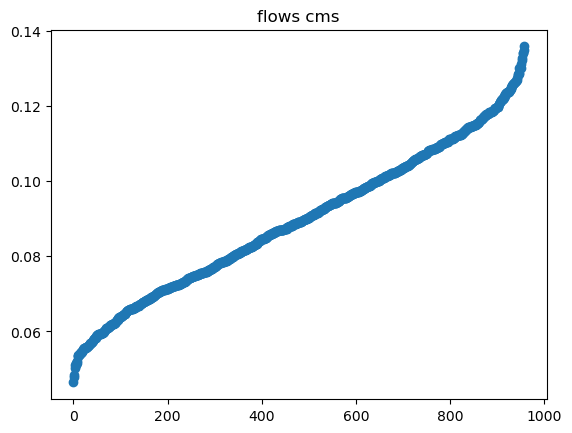

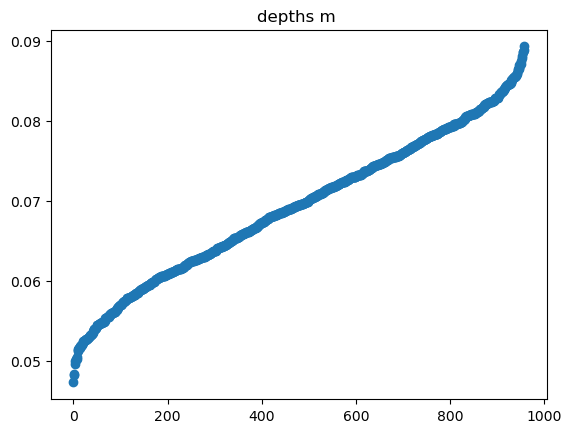

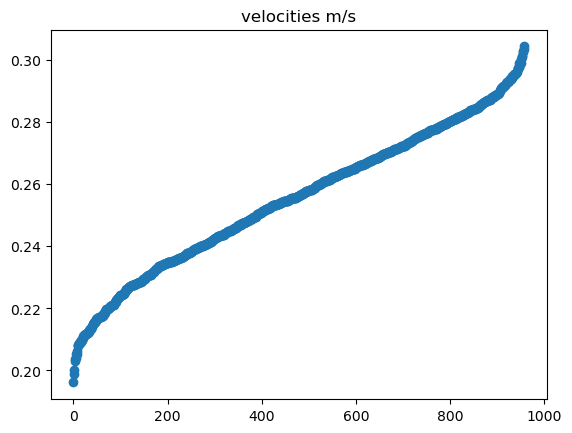

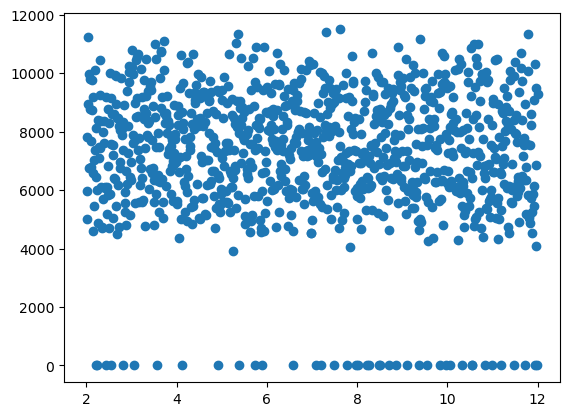

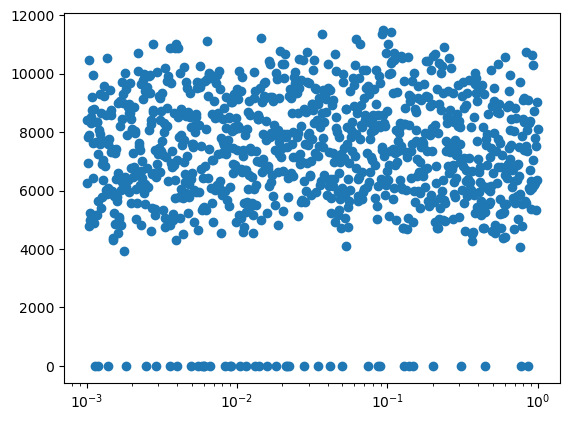

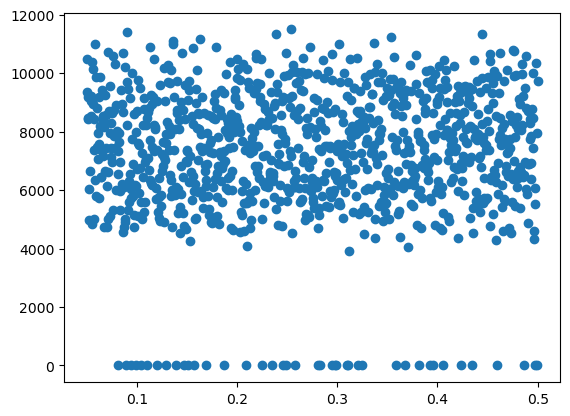

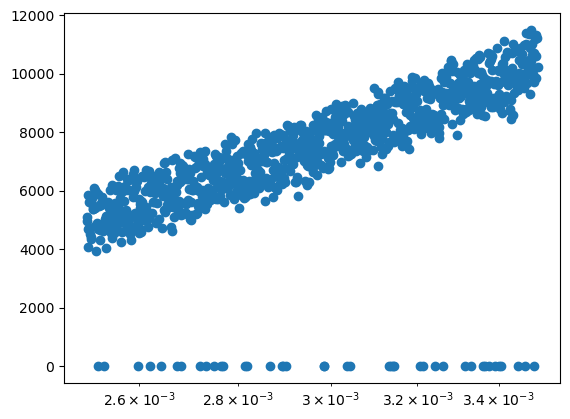

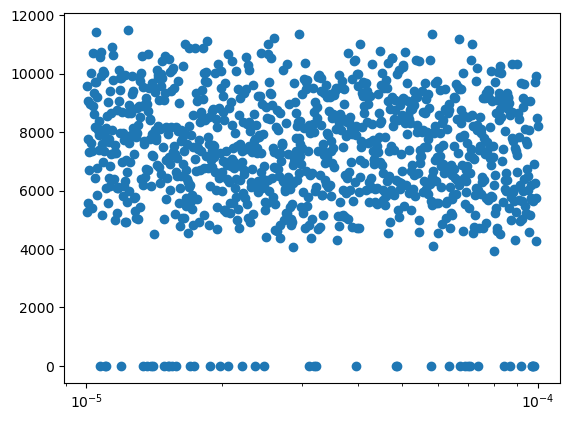

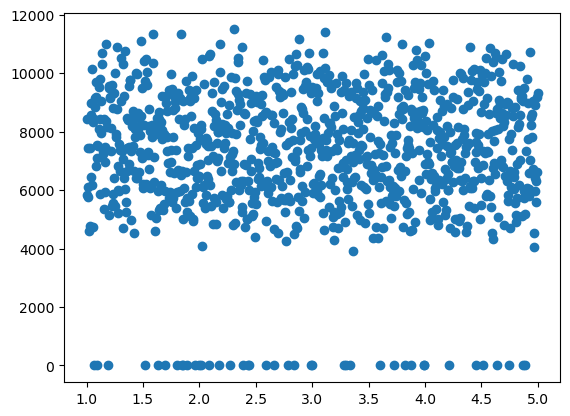

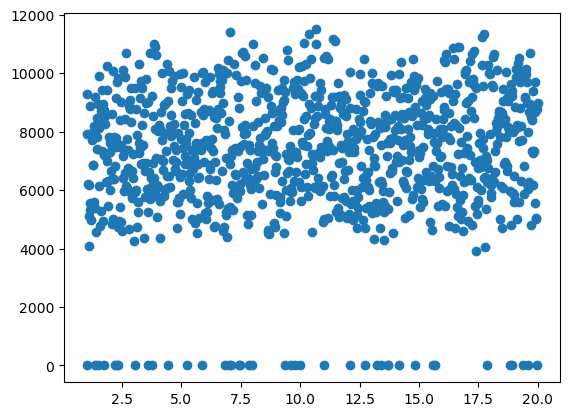

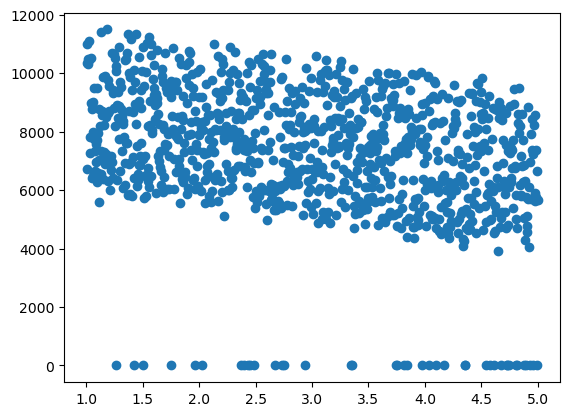

In [63]:
#
from flopy.utils.mflistfile import MfListBudget
#print(sfr.check())
print(sampling[1])
print(leakage_array[1])
mf_list = MfListBudget(modws+"/ScenarioSfrWell1000Test91.list")
#incremental, cumulative = mf_list.get_budget()
df_in, df_out = mf_list.get_dataframes()

display(df_out)
#print(sfr.get_slopes())
leakage = np.delete(leakage_array,np.where(leakage_array == -1)) / 84600
depth_array = np.delete(depth_array,np.where(depth_array == -1))
vel_array = np.nan_to_num(leakage / (depth_array * 5)) #V = Q/A with rectangular 5m channel

plt.title('flows cms')
plt.scatter(range(len(leakage)),sorted(leakage))
plt.show()

plt.title('depths m ')
plt.scatter(range(len(depth_array)),sorted(depth_array))
plt.show()

plt.title('velocities m/s')
plt.scatter(range(len(vel_array)),sorted(vel_array))
plt.show()

for i in range(npars):
    plt.scatter(sampling[:len(leakage_array), i], leakage_array)
    if i in logpars:
        plt.xscale('log')
    plt.show()


In [6]:
sampling = np.loadtxt("ModflowParams8-1000Test4.txt")
print(sampling[-1])

[7.08797415e+00 4.68023260e-02 6.67353018e-02 2.77475939e-03
 2.98086662e-05 3.13369438e+00 2.54820600e+00 1.73187392e+00]


In [5]:

#combined = np.hstack((sampling[:],leakage_array))
combined = sampling[:]
#print(len(combined))
error_list = np.loadtxt("ErrorSS_SfrWell1000Test10.txt")
if error_list.shape[0] > 0:
    eidx = np.array(error_list)[:,0].astype(int)
    print(eidx)
    error_free = np.delete(combined, eidx, axis=0)
   # error_free = [i for i in members if i not in eidx]
else:
    error_free = combined
#print(error_list[:,0])
#eidx = np.array(error_list)[:,0].astype(int)

#error_free = np.delete(combined, eidx, axis=0)
#print(error_free)

#np.savetxt("ModflowSfrWellOutput750Test5.txt", error_free)
np.savetxt("ModflowSfrWellOutput1000Test10.txt", error_free)

test = np.loadtxt("ModflowSfrWellOutput1000Test9.txt")
#if test:
print('yay', test.shape)
#print(test)

[ 28  29  62  74  95 109 120 127 137 141 144 172 183 204 221 257 274 279
 280 296 334 358 359 367 383 387 439 455 463 465 474 488 491 496 504 512
 521 550 570 576 585 592 594 640 643 661 679 736 750 773 794 826 837 856
 884 899 919 954 980 994 999]
yay (959, 9)


In [19]:
#Only for non pumping scenarios
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test10.pkl')
members = well_head_df.index.values
print(members.shape)
#error_list = np.loadtxt("ErrorSS_SfrWell1000Test10NoPumping.txt")
# eidx = np.array(error_list)[:,0].astype(int)
# print(eidx)
# error_free = [i for i in members if i not in eidx]
error_free = members
np.savetxt("ModflowSfrWellOutput1000Test10NoPumping.txt", error_free)

test = np.loadtxt("ModflowSfrWellOutput1000Test10NoPumping.txt")
print('yay', test.shape)


(825,)
yay (825,)


C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


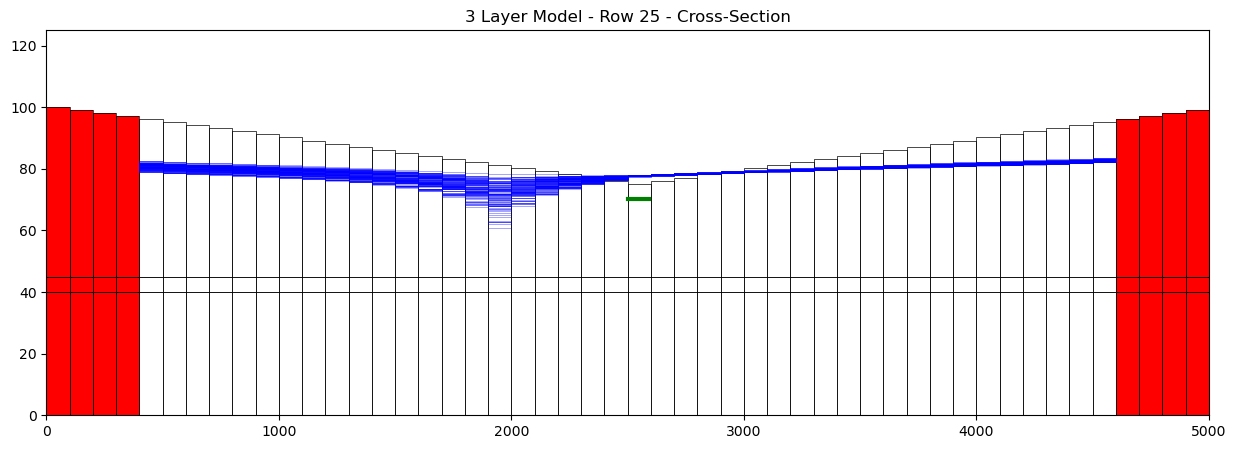

In [62]:
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test9.pkl')
#print(well_head_df.index.values)
#print(well_head_df.index.shape)
members = well_head_df.index.values

#temprange = np.arange(750)
#eidx = np.array(error_list)[:,0].astype(int)
#error_free = np.delete(temprange, eidx, axis=0)
mn = "D:/mfoutput/ScenarioSfrWell1000Test4_0.nam"
# error_list = np.loadtxt("ErrorSS_SfrWell750Test5.txt")
error_list = np.loadtxt("ErrorSS_SfrWell1000Test9.txt")

eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(1000)
error_free = np.delete(temprange, eidx, axis=0)

# if eidx.shape[0] == 0:
#     error_free = temprange #if no errors

    
m = flopy.modflow.Modflow.load(mn)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=m, line={'column':32 }) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')

linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model - Row 25 - Cross-Section')

#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
import random
#rand_list = [int(error_free[i][-1]) for i in range(0,75)]
#rand_list = random.choice(error_free,size=25)
#for i in rand_list: #rand_list[:100]:
for i in error_free[:100]:
    modelname = "ScenarioSfrWell1000Test9"+str(i)
    #modelname = "ScenarioSfrWell750Test5_"+str(i)

    fname = modws+'/'+modelname+'.hds'
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()
    wtup = xsect.plot_surface(head[0], lw=0.5, alpha=0.5)
    #wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.5, color='purple')
#plt.plot(np.arange(0,5000,100),reach['strtop'][:],color='green',linestyle='dashed', lw=1.5)
plt.plot(np.arange(2500,2600,10),np.repeat(reach['strtop'][32],10),color='green',linestyle='solid', lw=3)

#plt.legend()


In [352]:
print(reach['strtop'][25])

67.9


## Read SFR outputs

In [13]:
budgobj = flopy.utils.binaryfile.CellBudgetFile(modws+'/'+modelname+'.cbc')

sfrleak = budgobj.get_data(text="  STREAM LEAKAGE")[0]
#sfrleak[sfrleak == 0] = np.nan  # remove zero values
print(sfrleak)
# im = plt.imshow(
#     sfrleak[0], interpolation="none", cmap="coolwarm", vmin=-3, vmax=3
# )
# cb = plt.colorbar(im, label="SFR Leakage, in cubic feet per second");

[(1201, 0.        , 0.) (1202, 6.313402  , 0.) (1203, 6.093435  , 0.)
 (1204, 5.875448  , 0.) (1205, 5.659451  , 0.) (1206, 5.4454513 , 0.)
 (1207, 5.233456  , 0.) (1208, 5.0234704 , 0.) (1209, 4.815499  , 0.)
 (1210, 4.609542  , 0.) (1211, 4.4055977 , 0.) (1212, 4.203662  , 0.)
 (1213, 4.0037236 , 0.) (1214, 3.805768  , 0.) (1215, 3.609771  , 0.)
 (1216, 3.4156992 , 0.) (1217, 3.2235065 , 0.) (1218, 3.0331292 , 0.)
 (1219, 2.8444805 , 0.) (1220, 2.6574407 , 0.) (1221, 2.4718447 , 0.)
 (1222, 2.2874606 , 0.) (1223, 2.1039565 , 0.) (1224, 1.9208406 , 0.)
 (1225, 1.7373543 , 0.) (1226, 1.5522517 , 0.) (1227, 1.3632861 , 0.)
 (1228, 1.1657277 , 0.) (1229, 0.9459305 , 0.) (1230, 0.17940535, 0.)
 (1231, 0.        , 0.) (1232, 0.        , 0.) (1233, 0.        , 0.)
 (1234, 0.        , 0.) (1235, 0.        , 0.) (1236, 0.        , 0.)
 (1237, 0.        , 0.) (1238, 0.        , 0.) (1239, 0.        , 0.)
 (1240, 0.        , 0.) (1241, 0.        , 0.) (1242, 0.        , 0.)
 (1243, 0.        , 

In [7]:
#sfr_outfile = os.path.join(..', 'data', 'sfr_examples')
sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
testdf = sfrout.get_dataframe()
print(testdf)
sfrout = SfrFile(modws+'/ScenarioSfr750.sfr.out')
df = sfrout.get_dataframe()
print(df)

    layer  row  column  segment  reach       Qin   Qaquifer      Qout  Qovr  \
0       1   26       1        1      1    100.00    0.00000    100.00   0.0   
1       1   26       2        1      2    100.00 -560.93000    660.93   0.0   
2       1   26       3        1      3    660.93 -714.30000   1375.20   0.0   
3       1   26       4        1      4   1375.20 -776.38000   2151.60   0.0   
4       1   26       5        1      5   2151.60 -814.22000   2965.80   0.0   
5       1   26       6        1      6   2965.80 -839.21000   3805.00   0.0   
6       1   26       7        1      7   3805.00 -856.22000   4661.20   0.0   
7       1   26       8        1      8   4661.20 -869.40000   5530.60   0.0   
8       1   26       9        1      9   5530.60 -886.66000   6417.30   0.0   
9       1   26      10        1     10   6417.30 -934.77000   7352.10   0.0   
10      1   26      11        1     11   7352.10 -680.37000   8032.40   0.0   
11      1   26      12        1     12   8032.40 -67

FileNotFoundError: [Errno 2] No such file or directory: 'D:/mfoutput/ScenarioSfr750.sfr.out'

In [8]:
inds = df.segment == 1
#print(df.reach[inds].astype(str))
ax = df.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach")
testdf.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach", ax = ax)
ax.set_ylabel("Flow, in cubic feet per second")
ax.set_xlabel("SFR reach");

NameError: name 'df' is not defined

## read in outputs